In [12]:
from simple_pid import PID

In [84]:
hourly_growth_rate = 0.2

def simulation(duration_m, init_OD=1.0, pid=None, volume=2):
    OD_state = []
    OD = init_OD
    
    for i in range(duration_m):
        OD *= np.exp(hourly_growth_rate / 60)
        
        if (i % 30 == 0) and i > 0:
            output = pid(OD, dt=30)
            OD *= (1-(output * volume ) / 14)
            
    
        OD_state.append(OD)

    return OD_state



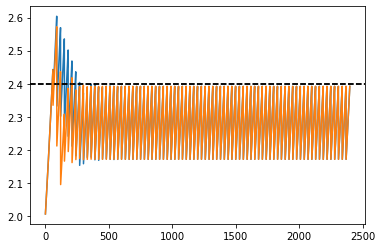

In [91]:
duration_m = 60 * 40
setpoint = 2.4
init_OD = 2.

pid = PID(-2, -0.15, -0, output_limits=(0, 1), sample_time=None)
pid.setpoint = setpoint

y = simulation(duration_m, init_OD=init_OD, pid=pid, volume=1.5)


t = np.arange(duration_m)
plt.plot(t, y)
plt.axhline(setpoint, c="k", ls="--")


pid = PID(-2, -0.15, -0, output_limits=(0, 1), sample_time=None)
pid.setpoint = setpoint

y = simulation(duration_m, init_OD=init_OD, pid=pid, volume=2)


t = np.arange(duration_m)
plt.plot(t, y)
plt.axhline(setpoint, c="k", ls="--")